In [160]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os

import pandas as pandas
import tensorflow as tf
import cv2
import seaborn
import pandas
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow_estimator.python.estimator import early_stopping

# Chargement du dataset
- Chargement dataset
- Data augmentation et préprocessing lié au déséquilibrage
- Étudier SMOTE, pondération

In [164]:
PATH = "datasets/Qualite"

In [165]:
# étiquettes
class_names = ["FaceQual0","FaceQual1","FaceQual2","FaceQual3"]

In [166]:
batch_size = 32
img_height = 300
img_width = 300
IMG_SIZE = (img_width, img_height)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int"
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 18695 files belonging to 4 classes.
Using 14956 files for training.
Found 18695 files belonging to 4 classes.
Using 3739 files for validation.


In [167]:
# Crée jeu de tests
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 3)
validation_ds = validation_ds.skip(val_batches // 3)

In [168]:
# affichage
imgs_take = train_ds.take(1)
imgs = {'img':[], 'label':[]}
for images, labels in imgs_take:
  for i in range(9):
      imgs['img'].append(images[i])
      imgs['label'].append(class_names[labels[i]])

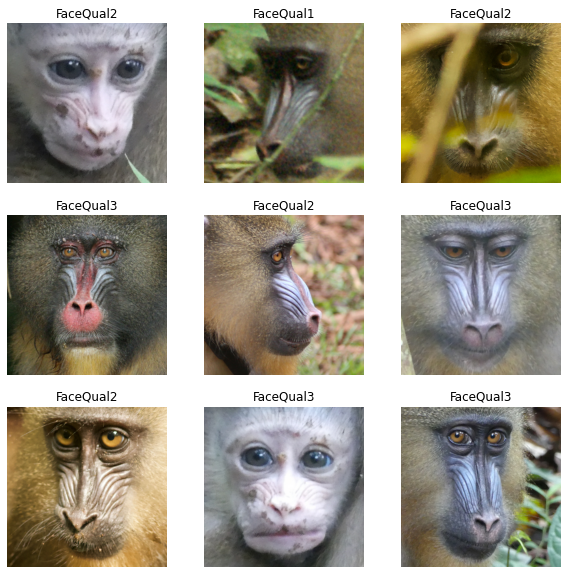

In [169]:
# affichage haute qualité
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs['img'][i].numpy().astype("uint8"))
    plt.title(imgs['label'][i])
    plt.axis("off")

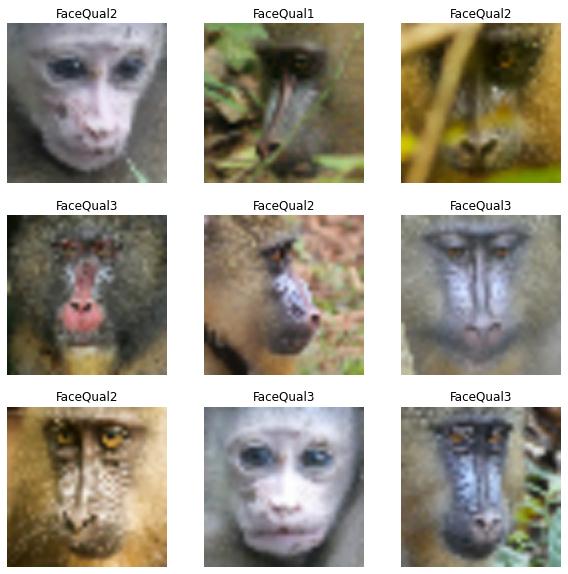

In [170]:
# generating the kernel
blur = 9
downscale = 40
kernel = np.ones((blur,blur),np.uint8)/pow(blur, 2)

# potentiel augmentation par dégradation des images de haute qualité
# a étudier : dégradation par encodage JPEG à fort taux de compression
# actuel : downscale => upscale => blur
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = tf.image.resize(imgs['img'][i], [downscale, downscale], method="nearest")
    img = tf.image.resize(img, [300, 300], method="nearest")
    output = cv2.filter2D(img.numpy(), -1, kernel)
    img = tf.convert_to_tensor(output)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(imgs['label'][i])
    plt.axis("off")

# Chargement du modèle et transfer learning
- Modèle existant : MobileNet V2, VGG16, EfficientNet...
- Poids existant : ImageNet
- Ajouter couches de convolutions pour extraire les features spécialisées

In [171]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # modele MobileNet V2 (rapide et correct)
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1) # [0, 255] => [-1, 1]

In [172]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_width, img_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [52]:
# Load model from file
model = tf.keras.models.load_model('saved_models/MNV2_GEL_IMBALANCED.h5')

OSError: SavedModel file does not exist at: saved_models/MNV2_GEL_IMBALANCED.h5\{saved_model.pbtxt|saved_model.pb}

In [173]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 300, 300, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 300, 300, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 1,866,564
Non-trainable params: 396,544
___________________________________________

In [174]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 1280)


In [175]:
# gel : a voir
base_model.trainable = False

In [176]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [186]:
global_conv2d_layer = tf.keras.layers.Dense(1280, activation="relu")
feature_batch_conv2d = global_conv2d_layer(feature_batch)

In [187]:
prediction_layer = tf.keras.layers.Dense(4, activation="softmax") # prédiction sur 4 classes (4 neurones)

In [217]:
class CustomModel:
    def __init__(self): # a splitter apres pour rajouter les layers a la vole
        inputs = tf.keras.Input(shape=(img_width, img_height, 3))
        x = preprocess_input(inputs)
        x = base_model(x, training=False) # mobile net v2
        x = global_average_layer(x) # moyenne des features
        x = global_conv2d_layer(x) # convolution 2d
        x = global_conv2d_layer(x) # convolution 2d
        outputs = prediction_layer(x) # prediction
        self.model = tf.keras.Model(inputs, outputs)
    def compile(self, learning_rate=0.0001):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[
                  "accuracy",
              ])
    def run(self, epochs=10):
        self.loss0, self.accuracy0 = model.evaluate(validation_ds)
        self.history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=validation_ds)
    def save_history(self, filename: str):
         pandas.DataFrame(self.history.history).to_csv("saved_model/" + filename + ".csv")

In [ ]:
model = CustomModel()

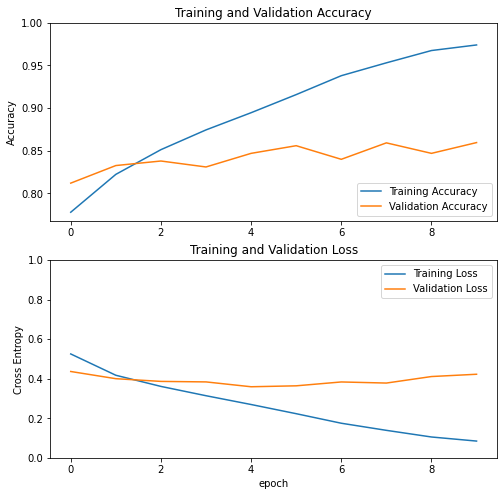

In [196]:
# graphes accuracy + loss
# si c'est pas mal on passe à la suite, sinon on refait au dessus
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

[2.0940279e-06 3.3116350e-05 1.9211402e-03 9.9804366e-01]
[7.2331577e-06 1.1671638e-03 6.4432114e-01 3.5450444e-01]
[3.0628126e-08 6.4686692e-06 9.9937892e-01 6.1453792e-04]
[1.1130091e-08 8.0888967e-08 2.7026000e-04 9.9972957e-01]
[8.2572150e-01 1.7395166e-01 3.0316933e-04 2.3665101e-05]
[1.6088018e-02 9.8385924e-01 5.1674444e-05 1.0734000e-06]
[3.2058571e-07 4.3484270e-06 9.9744570e-01 2.5496364e-03]
[3.8032370e-06 8.6166765e-05 9.9977702e-01 1.3306421e-04]
[1.0029124e-06 1.1189567e-04 2.1359088e-01 7.8629625e-01]


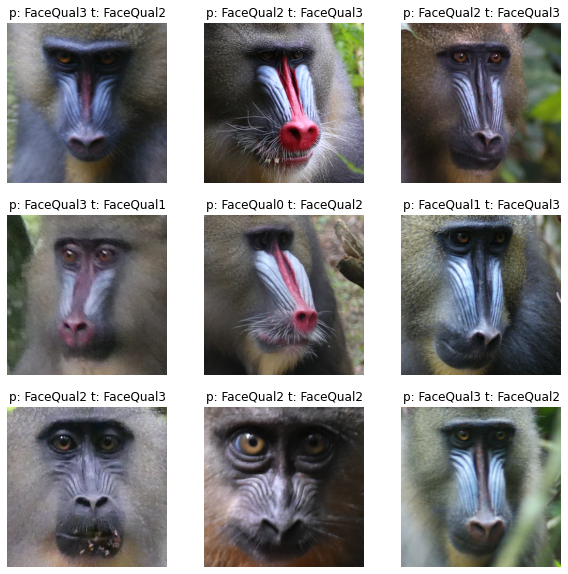

In [197]:
predictions = model.predict(test_dataset)
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    print(predictions[i])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("p: " + class_names[np.argmax(predictions[i])] + " t: " + class_names[labels[i]])
    plt.axis("off")

In [198]:
model.save("saved_model/mobilenetv2_qualite_gel2.h5")

C:\Users\maxim\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# On fine-tune le modèle une fois qu'il a "appris au maximum"
- defreezing de layers supérieurs
- il faudra faire varier aussi sans doute le learning rate

In [199]:
base_model.trainable = True

In [200]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [201]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), # learning rate + faible que dans la 1re partie
              metrics=['accuracy'])

In [202]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds,
                         callbacks=[early_stopping])

Epoch 10/20
468/468 [==============================] - 50s 100ms/step - loss: 0.0929 - accuracy: 0.9680 - val_loss: 0.4060 - val_accuracy: 0.8568
Epoch 11/20
468/468 [==============================] - 47s 100ms/step - loss: 0.0621 - accuracy: 0.9810 - val_loss: 0.5028 - val_accuracy: 0.8408
Epoch 12/20
468/468 [==============================] - 47s 99ms/step - loss: 0.0481 - accuracy: 0.9862 - val_loss: 0.4502 - val_accuracy: 0.8678
Epoch 13/20
468/468 [==============================] - 46s 99ms/step - loss: 0.0361 - accuracy: 0.9905 - val_loss: 0.6922 - val_accuracy: 0.8175
Epoch 14/20
468/468 [==============================] - 46s 99ms/step - loss: 0.0294 - accuracy: 0.9918 - val_loss: 0.5972 - val_accuracy: 0.8448
Epoch 15/20
468/468 [==============================] - 47s 101ms/step - loss: 0.0240 - accuracy: 0.9941 - val_loss: 0.4567 - val_accuracy: 0.8695
Epoch 16/20
468/468 [==============================] - 47s 100ms/step - loss: 0.0186 - accuracy: 0.9953 - val_loss: 0.5057 - va

In [205]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [206]:
pandas.DataFrame(history.history).to_csv("saved_model/history2.csv")

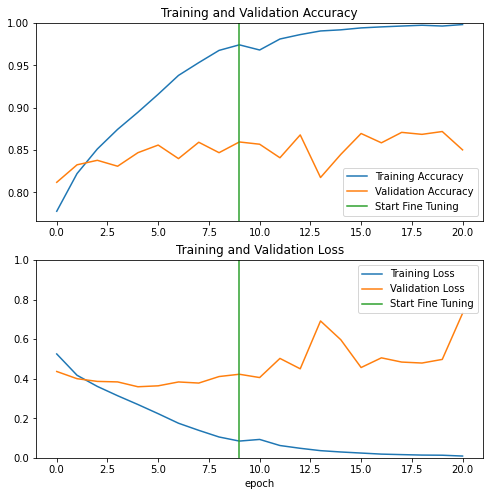

In [207]:
# graphes accuracy + loss
# si c'est pas mal on passe à la suite, sinon on refait au dessus


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [208]:
model.save("saved_model/mobilenetv2_qualite_degel2.h5")

C:\Users\maxim\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Analyse des résultats
- précision prédiction
- mesure du déséquilibre

[2.8362408e-08 1.2451559e-07 1.6319480e-03 9.9836797e-01]
[1.5841323e-10 1.8977799e-08 5.3655696e-01 4.6344304e-01]
[8.7369436e-01 1.2627520e-01 3.0398280e-05 5.5100652e-10]
[9.8625126e-09 9.9999976e-01 2.6046624e-07 1.0200033e-11]
[1.9120801e-08 5.9420900e-06 9.0793556e-01 9.2058539e-02]
[1.5744813e-08 2.0056491e-06 9.9938238e-01 6.1558298e-04]
[3.1947407e-09 6.4784610e-05 9.9993515e-01 2.5411661e-11]
[1.00731374e-13 1.54713142e-09 1.00000000e+00 9.19364673e-09]
[1.2905346e-07 3.7875150e-05 1.3524699e-01 8.6471498e-01]
[1.0088342e-11 3.2046246e-06 9.9999666e-01 9.3261711e-08]
[4.940904e-10 9.787563e-08 9.953816e-01 4.618327e-03]
[3.8196960e-13 2.6345096e-10 7.5508247e-04 9.9924493e-01]
[1.8164758e-07 1.8864608e-04 9.9952412e-01 2.8698315e-04]
[2.6706271e-11 3.3942904e-09 1.0000000e+00 4.7141574e-10]
[1.7457262e-07 3.1908709e-04 3.2649973e-01 6.7318100e-01]
[6.1842698e-11 2.1500672e-09 9.9999309e-01 6.9597140e-06]
[1.6834768e-11 2.4485316e-09 4.4750285e-01 5.5249715e-01]
[7.2616246e-11

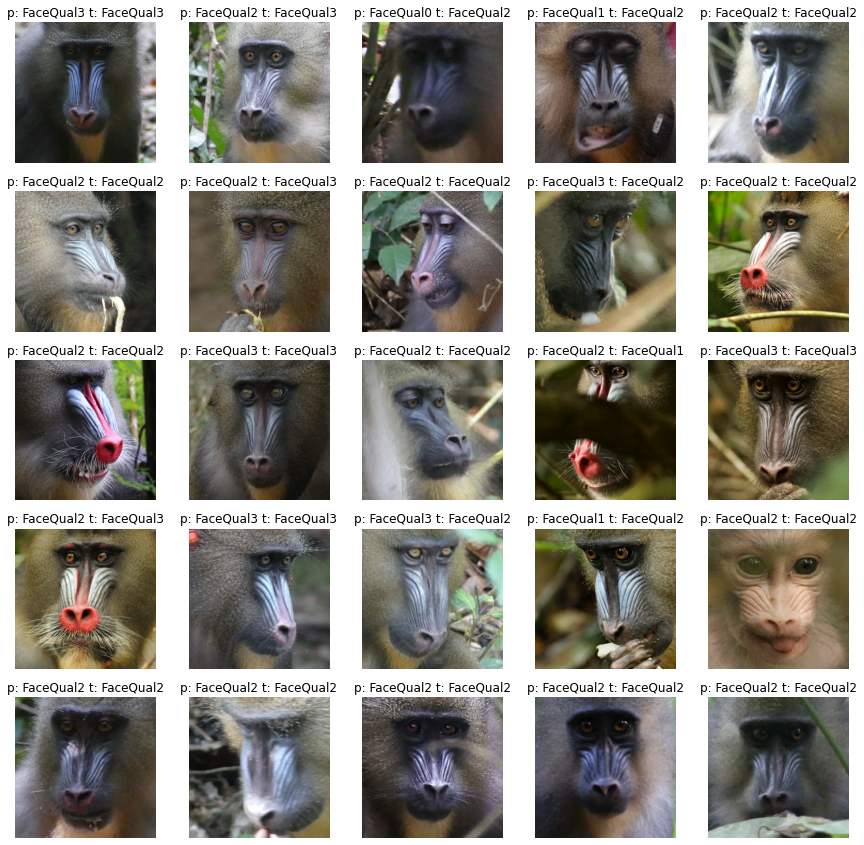

In [209]:
predictions = model.predict(test_dataset)
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
  for i in range(25):
    print(predictions[i])
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("p: " + class_names[np.argmax(predictions[i])] + " t: " + class_names[labels[i]])
    plt.axis("off")

In [210]:
# Classification report

y_valid = np.concatenate([y for x,y in validation_ds], axis=0)
y_pred = np.argmax(model.predict(validation_ds), axis=1)

print(classification_report(y_valid, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   FaceQual0       0.00      0.00      0.00        34
   FaceQual1       0.08      0.07      0.07       192
   FaceQual2       0.59      0.69      0.64      1810
   FaceQual3       0.30      0.22      0.25       967

    accuracy                           0.49      3003
   macro avg       0.24      0.24      0.24      3003
weighted avg       0.46      0.49      0.47      3003



# Matrice de confusion
On veut voir apparaître sur la matrice de confusion une diagonale qui symboliserait une correspondance parfaite entre classes annotées et classes prédites.
L'écart entre classe prédite et annotée doit être minimale (une erreur de 1 est moins grave qu'une erreur de 3).
Cela démontre également si le modèle est intelligent (= ne triche pas avec le déséquilibre).

In [211]:
# Matrice de confusion
def show_confusion_matrix(y_valid, y_prediction):
    cm = confusion_matrix(y_valid, y_pred)
    # Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
    cm = pandas.DataFrame(cm,
                         index = ["FaceQual0","FaceQual1","FaceQual2","FaceQual3"],
                         columns = ["FaceQual0","FaceQual1","FaceQual2","FaceQual3"])
    #Plotting the confusion matrix
    plt.figure(figsize=(10,10))
    seaborn.heatmap(cm, annot=True)
    plt.title('Matrice de confusion')
    plt.ylabel('Valeurs annotées')
    plt.xlabel('Valeurs prédites')
    plt.show()

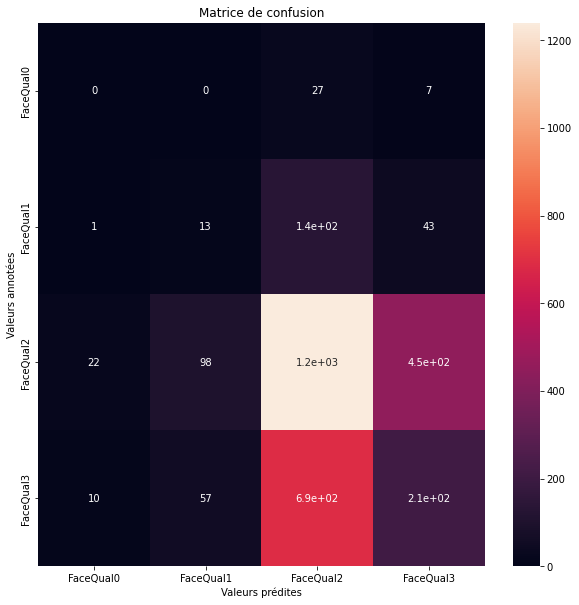

In [212]:
show_confusion_matrix(y_valid,y_pred)

ROC AUC score: 0.4932286426128611


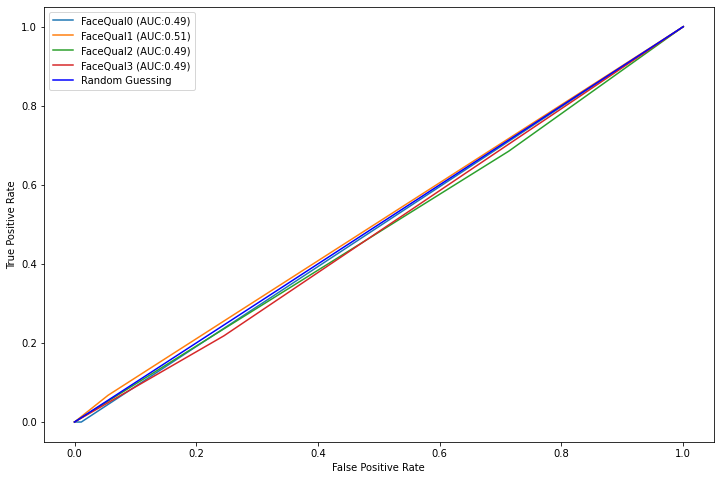

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


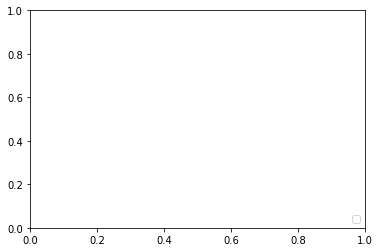

In [215]:
# Graphe ROC

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_valid, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_valid)
    y_valid = lb.transform(y_valid)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_valid[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_valid, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_valid, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

multiclass_roc_auc_score(y_valid, y_pred)
plt.legend(loc='lower right');

# Déséquilibrage des classes : pondération

In [216]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

NameError: name 'train_features' is not defined

In [ ]:
class_weight={
    "FaceQual0":(1/33)*(67/2.0),
    "FaceQual1":(1/168)*(352/2.0),
    "FaceQual2":0.5988767050013373,
    "FaceQual3":0.3201390746188821
}